#  Import data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

## Organize Data by Type

In [4]:
import os
import shutil

# Detect environment and set appropriate path prefix
if os.path.exists('./data/train_data'):
    PATH_PREFIX = './'
    print("✓ Found ./data/train_data (Local or Colab)")
elif os.path.exists('/data/train_data'):
    PATH_PREFIX = '/'
    print("✓ Found /data/train_data (Kaggle)")
elif os.path.exists('data/train_data'):
    PATH_PREFIX = ''
    print("✓ Found data/train_data (Current directory)")
else:
    print("✗ Data not found in expected locations!")
    PATH_PREFIX = '/'

print(f"Using PATH_PREFIX: {PATH_PREFIX}")

print("="*80)
print("ORGANIZING DATA INTO SEPARATE DIRECTORIES BY TYPE")
print("="*80)

# Define source directories
train_data_dir = PATH_PREFIX + 'data/train_data/'
test_data_dir = PATH_PREFIX + 'data/test_data/'

# Define target directories for organized data
train_img_dir = PATH_PREFIX + 'data/train_img/'
train_mask_dir = PATH_PREFIX + 'data/train_mask/'
test_img_dir = PATH_PREFIX + 'data/test_img/'
test_mask_dir = PATH_PREFIX + 'data/test_mask/'

train_labels = pd.read_csv(PATH_PREFIX + 'data/train_labels.csv')

# Create target directories if they don't exist
for directory in [train_img_dir, train_mask_dir, test_img_dir, test_mask_dir]:
    os.makedirs(directory, exist_ok=True)

# Function to organize files by type
def organize_data_by_type(source_dir, img_dir, mask_dir):
    """
    Move image and mask files from source directory to separate directories.
    Only moves files if they don't already exist in the target directory.
    """
    if not os.path.exists(source_dir):
        print(f"⚠ Warning: Source directory not found: {source_dir}")
        return 0, 0
    
    files = os.listdir(source_dir)
    img_count = 0
    mask_count = 0
    
    for filename in files:
        source_path = os.path.join(source_dir, filename)
        
        # Skip if not a file
        if not os.path.isfile(source_path):
            continue
        
        # Determine target directory based on filename prefix
        if filename.startswith('img_'):
            target_path = os.path.join(img_dir, filename)
            if not os.path.exists(target_path):
                shutil.copy2(source_path, target_path)
                img_count += 1
        elif filename.startswith('mask_'):
            target_path = os.path.join(mask_dir, filename)
            if not os.path.exists(target_path):
                shutil.copy2(source_path, target_path)
                mask_count += 1
    
    return img_count, mask_count

# Organize training data
print("\nOrganizing training data...")
train_img_moved, train_mask_moved = organize_data_by_type(
    train_data_dir, train_img_dir, train_mask_dir
)
print(f"  Images: {train_img_moved} files copied to {train_img_dir}")
print(f"  Masks: {train_mask_moved} files copied to {train_mask_dir}")

# Organize test data
print("\nOrganizing test data...")
test_img_moved, test_mask_moved = organize_data_by_type(
    test_data_dir, test_img_dir, test_mask_dir
)
print(f"  Images: {test_img_moved} files copied to {test_img_dir}")
print(f"  Masks: {test_mask_moved} files copied to {test_mask_dir}")

# Verify organization
print("\n" + "="*80)
print("DATA ORGANIZATION SUMMARY")
print("="*80)
print(f"Train images: {len(os.listdir(train_img_dir)) if os.path.exists(train_img_dir) else 0} files in {train_img_dir}")
print(f"Train masks: {len(os.listdir(train_mask_dir)) if os.path.exists(train_mask_dir) else 0} files in {train_mask_dir}")
print(f"Test images: {len(os.listdir(test_img_dir)) if os.path.exists(test_img_dir) else 0} files in {test_img_dir}")
print(f"Test masks: {len(os.listdir(test_mask_dir)) if os.path.exists(test_mask_dir) else 0} files in {test_mask_dir}")
print("="*80)
print("Data organization complete!")
print("  - Organized copies are in train_img/, train_mask/, test_img/, test_mask/")

✓ Found ./data/train_data (Local or Colab)
Using PATH_PREFIX: ./
ORGANIZING DATA INTO SEPARATE DIRECTORIES BY TYPE

Organizing training data...
  Images: 581 files copied to ./data/train_img/
  Masks: 581 files copied to ./data/train_mask/

Organizing test data...
  Images: 477 files copied to ./data/test_img/
  Masks: 477 files copied to ./data/test_mask/

DATA ORGANIZATION SUMMARY
Train images: 581 files in ./data/train_img/
Train masks: 581 files in ./data/train_mask/
Test images: 477 files in ./data/test_img/
Test masks: 477 files in ./data/test_mask/
Data organization complete!
  - Organized copies are in train_img/, train_mask/, test_img/, test_mask/


# Preprocessing

## Remove Shrek & Slimes

In [5]:
# Parse the contaminated indices from the text file
contaminated_indices = []
with open('shrek_and_slimes.txt', 'r') as f:
    for line in f:
        line = line.strip()
        if line and line.isdigit():
            contaminated_indices.append(int(line))

print(f"Found {len(contaminated_indices)} contaminated samples to remove")

# Define directories to clean (both img and mask directories)
train_img_dir_clean = PATH_PREFIX + 'data/train_img/'
train_mask_dir_clean = PATH_PREFIX + 'data/train_mask/'

# Remove corresponding image and mask files from both directories
removed_count = 0
for idx in contaminated_indices:
    img_name = f'img_{idx:04d}.png'
    mask_name = f'mask_{idx:04d}.png'
    
    # Remove from train_img directory
    img_path = os.path.join(train_img_dir_clean, img_name)
    if os.path.exists(img_path):
        os.remove(img_path)
        removed_count += 1
    
    # Remove from train_mask directory
    mask_path = os.path.join(train_mask_dir_clean, mask_name)
    if os.path.exists(mask_path):
        os.remove(mask_path)
        removed_count += 1

print(f"Removed {removed_count} files from organized directories")

# Update train_labels by removing contaminated indices
train_labels = train_labels[~train_labels['sample_index'].str.extract(r'(\d+)')[0].astype(int).isin(contaminated_indices)]
print(f"Training labels updated: {len(train_labels)} samples remaining")

Found 110 contaminated samples to remove
Removed 0 files from organized directories
Training labels updated: 581 samples remaining


## Masks as Focus Filters

## Generative Mask Conditioning

**Philosophy**: *"Few images you have? But the shapes (masks) you possess. Use a generative model, conditioned on these masks, to dream new textures into old forms."*

**Pipeline**:
```
Original Images + Masks
    ↓
[GENERATIVE] Generate synthetic images from masks
    ↓
Real + Synthetic Images (with masks)
    ↓
[AUGMENTATION] Geometric transforms on all
    ↓
Maximum Diversity Dataset
```

Found 1 GPU(s) available:
 GPU 0: NVIDIA GeForce GTX 1650 with Max-Q Design
Single GPU training
GENERATIVE MASK CONDITIONING SETUP (Pix2Pix GAN)
Adding synthetic images to: ./data/train_img/
Adding synthetic masks to: ./data/train_mask/
Synthetic multiplier: 3x per image
Using GPU: True
Method: Lightweight Pix2Pix GAN (~50MB)
✓ Pix2Pix Generator initialized
  Parameters: 6,171,651
  Size: ~23.5 MB
  Device: GPU

✓ Class-specific color profiles defined
  Classes: ['Triple negative', 'Luminal A', 'Luminal B', 'HER2(+)']
✓ Helper functions defined
  - prepare_mask_for_gan(): Convert masks to GAN tensor format
  - apply_color_jitter(): Class-specific color augmentation
  - generate_synthetic_image_gan(): GAN-based generation with blending

GENERATING SYNTHETIC IMAGES FROM MASKS
Generating 3 synthetic images per real image
Total real images: 581
Expected synthetic images: 1743

  Progress: 10/581 images processed (30 synthetic images generated)
  Progress: 20/581 images processed (60 synthe

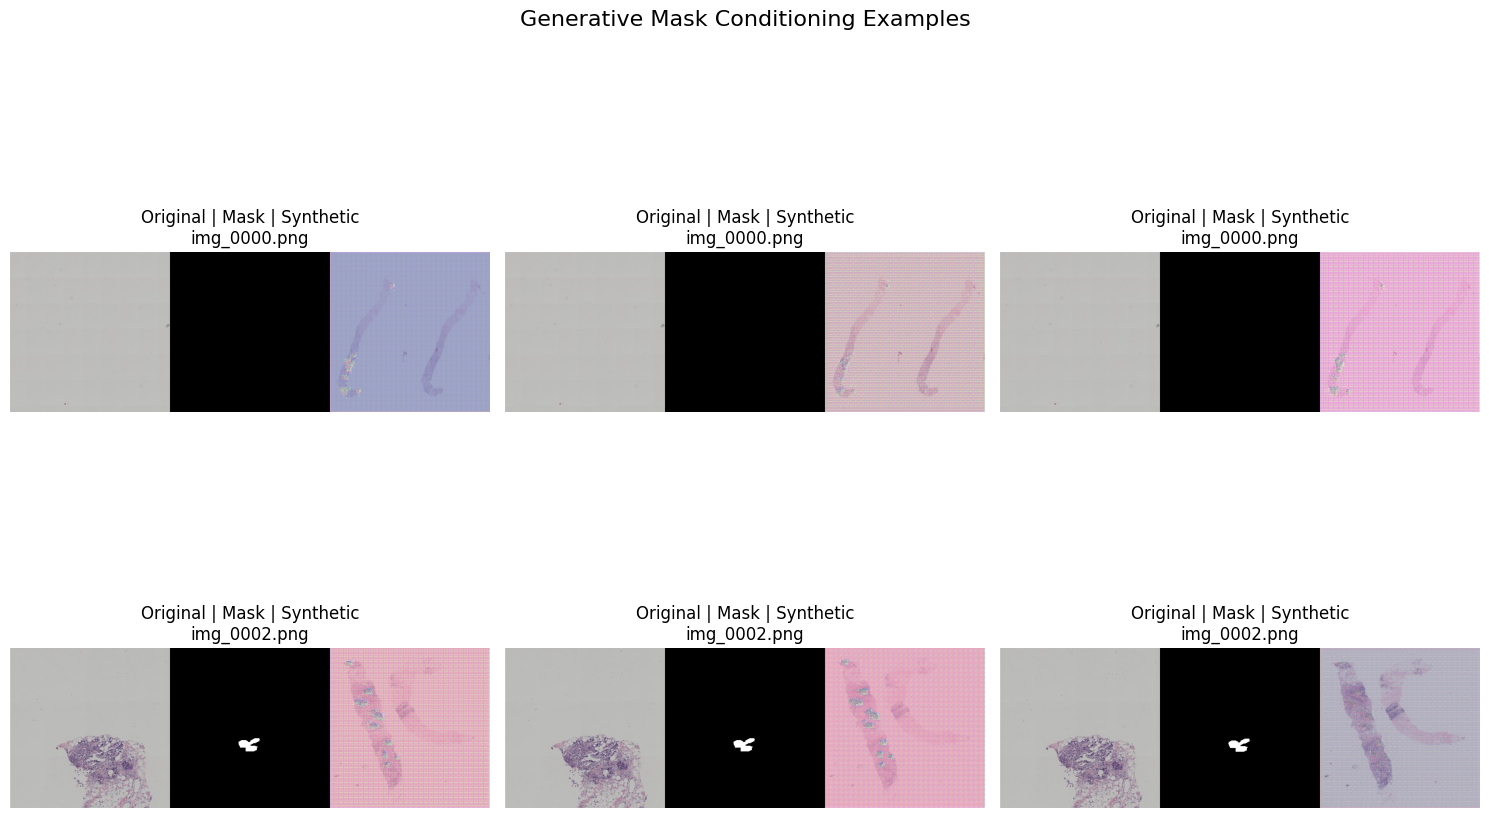


✓ Showing 6 synthetic examples
  Left: Original image | Center: Mask (guide) | Right: Synthetic image
Found 1743 synthetic images in existing directory

Dataset expansion complete:
  Real images: 581
  Synthetic images: 1743
  Total: 2324
  Expansion ratio: 4.00x

Class distribution (Real + Synthetic):
label
HER2(+)            600
Luminal A          632
Luminal B          816
Triple negative    276
Name: count, dtype: int64


In [6]:
from prep_gen_mask import generate_synthetic_images

train_labels = generate_synthetic_images(train_img_dir, train_mask_dir, train_labels, synthetic_multiplier=3)

## Augmentation


Class Distribution After Removal of Contaminated Images
label
HER2(+)            600
Luminal A          632
Luminal B          816
Triple negative    276
Name: count, dtype: int64

Total samples: 2324

STATISTICS FOR AUGMENTATION

Class with the most samples (Majority): Luminal B (816 samples)
Class with the fewest samples (Minority): Triple negative (276 samples)

Imbalance ratio (Max/Min): 2.96x

RECOMMENDED AUGMENTATION STRATEGY

Augmentations to apply (as suggested by the professor):
  1. Horizontal Flip (p=0.5)
  2. Vertical Flip (p=0.5)
  3. Random Translation (0.2, 0.2)
  4. Random Zoom/Scale (0.8, 1.2)
  [EXCLUDE: Random Rotation - would change dimensions]


BALANCED STRATEGY: ALL CLASSES GROW TO A FIXED AND EQUAL NUMBER

Target: 1000 samples for EACH class

DATASET AFTER BALANCED AUGMENTATION
Class                Original        New Augment     Augmentations per image   Total          
--------------------------------------------------------------------------------
HER2(+)   

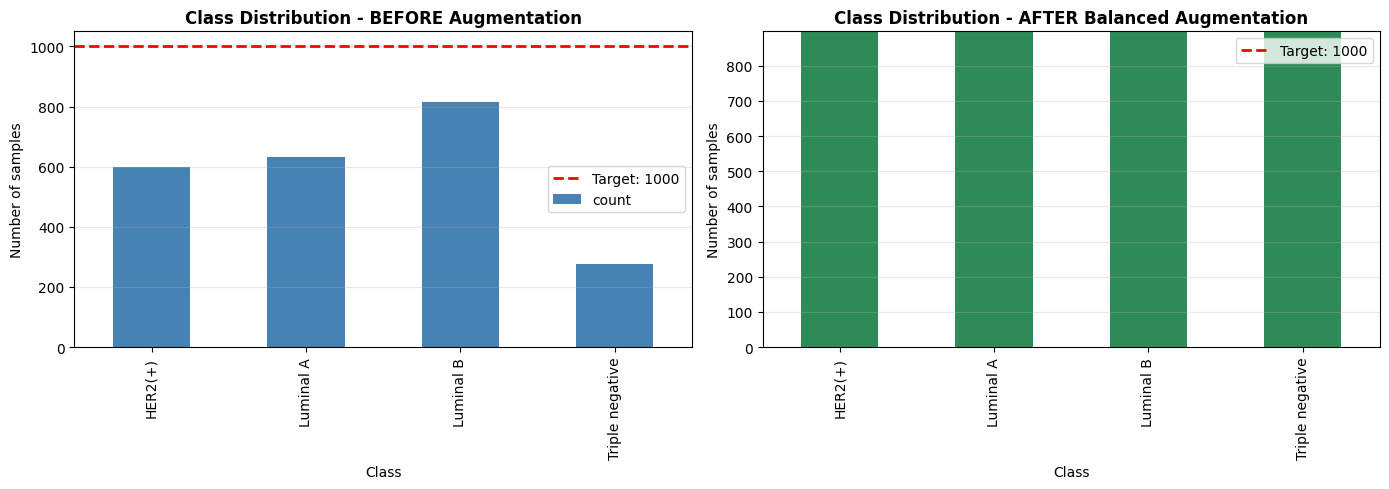


AUTOMATIC AUGMENTATION CONFIGURATION
Using AutoAugment with policy: AutoAugmentPolicy.IMAGENET
  - Automatically applies learned augmentation combinations
  - Optimized for ImageNet-like datasets

Mask augmentation:
  - Synchronized geometric transforms only (flip operations)
  - No color/brightness changes (masks are binary/grayscale)

STARTING DUAL-PATH AUTOMATIC AUGMENTATION PROCESS
Augmentation Policy: autoaugment
Augmenting both IMAGES and MASKS
  - Images: Automatic augmentation (color, geometric, etc.)
  - Masks: Synchronized geometric transforms only
Saving augmented files to same directories as originals

--------------------------------------------------------------------------------
Class: HER2(+)
Augmentations to generate: 400
--------------------------------------------------------------------------------


  HER2(+): 100%|██████████| 600/600 [00:30<00:00, 19.86it/s]


  HER2(+): Completed! 400 image-mask pairs generated

--------------------------------------------------------------------------------
Class: Luminal A
Augmentations to generate: 368
--------------------------------------------------------------------------------


  Luminal A: 100%|██████████| 632/632 [00:27<00:00, 22.93it/s]


  Luminal A: Completed! 368 image-mask pairs generated

--------------------------------------------------------------------------------
Class: Luminal B
Augmentations to generate: 184
--------------------------------------------------------------------------------


  Luminal B: 100%|██████████| 816/816 [00:31<00:00, 26.29it/s]


  Luminal B: Completed! 184 image-mask pairs generated

--------------------------------------------------------------------------------
Class: Triple negative
Augmentations to generate: 724
--------------------------------------------------------------------------------


  Triple negative: 100%|██████████| 276/276 [00:31<00:00,  8.66it/s]


  Triple negative: Completed! 724 image-mask pairs generated

AUTOMATIC AUGMENTATION COMPLETED!
Total augmented image-mask pairs generated: 1676
Augmented images added to: ./data/train_img/
Augmented masks added to: ./data/train_mask/

Total images in directory: 4000
Total masks in directory: 4000


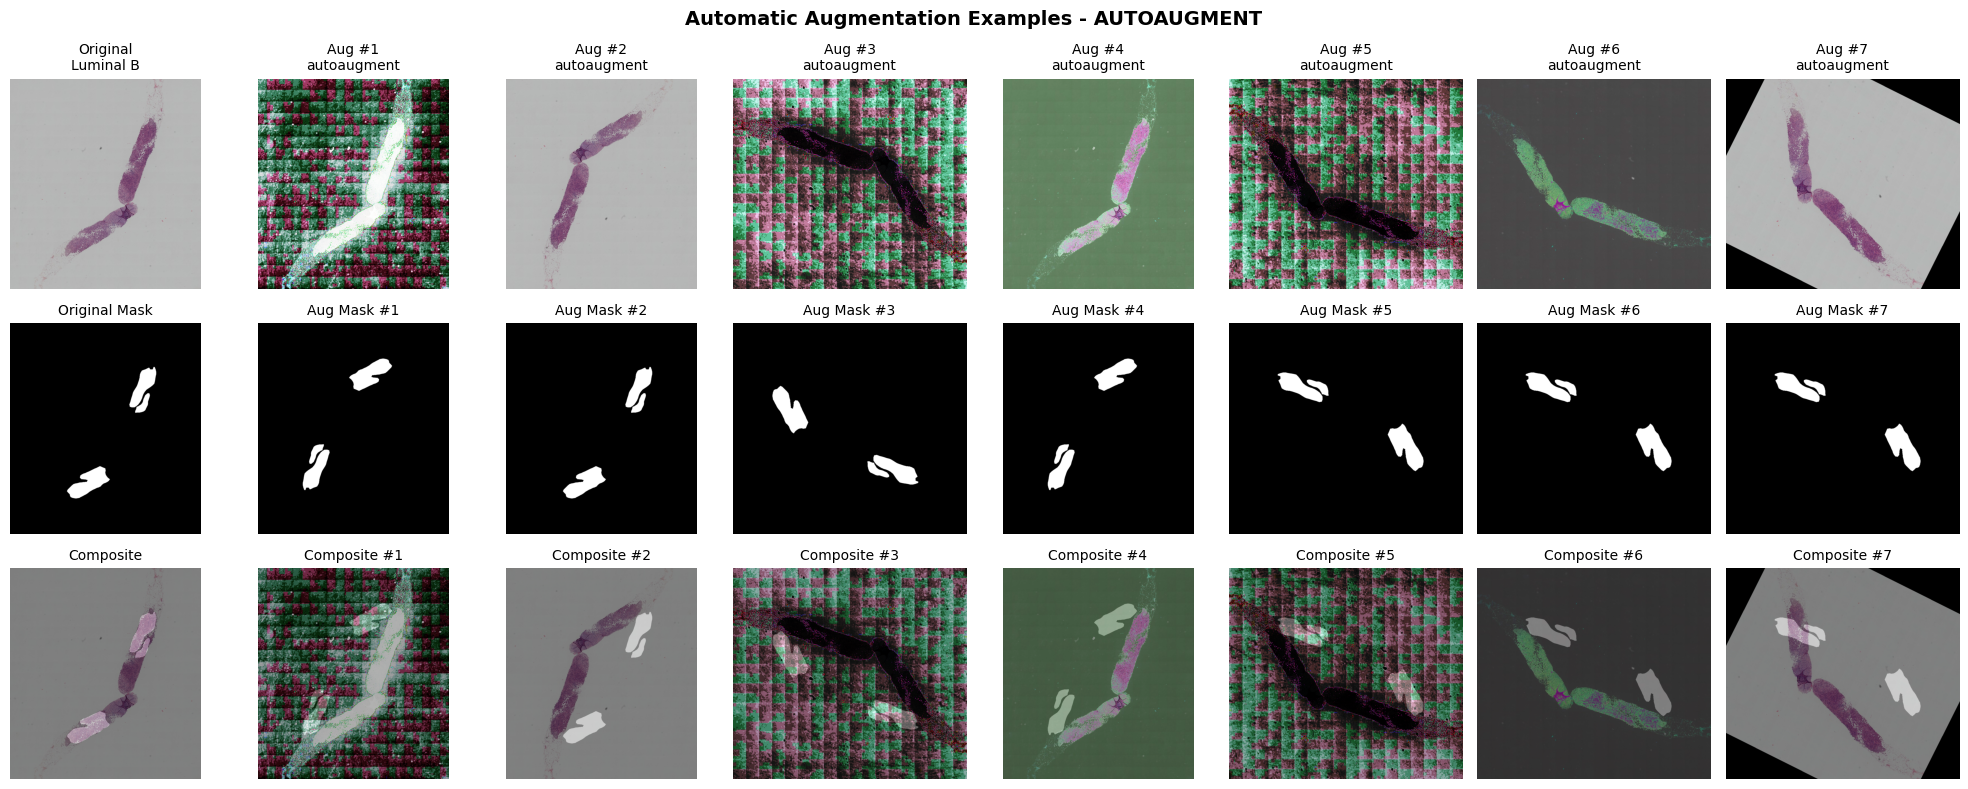


✓ Showing 8 augmentation variations
  Policy: autoaugment
  Notice the variety in color, brightness, contrast, and geometric transforms


In [7]:
from prep_aug import augment_images

train_labels = augment_images(train_img_dir, train_mask_dir, train_labels, augmentation_policy='autoaugment', target_samples=1000)

## Crop Masked Images

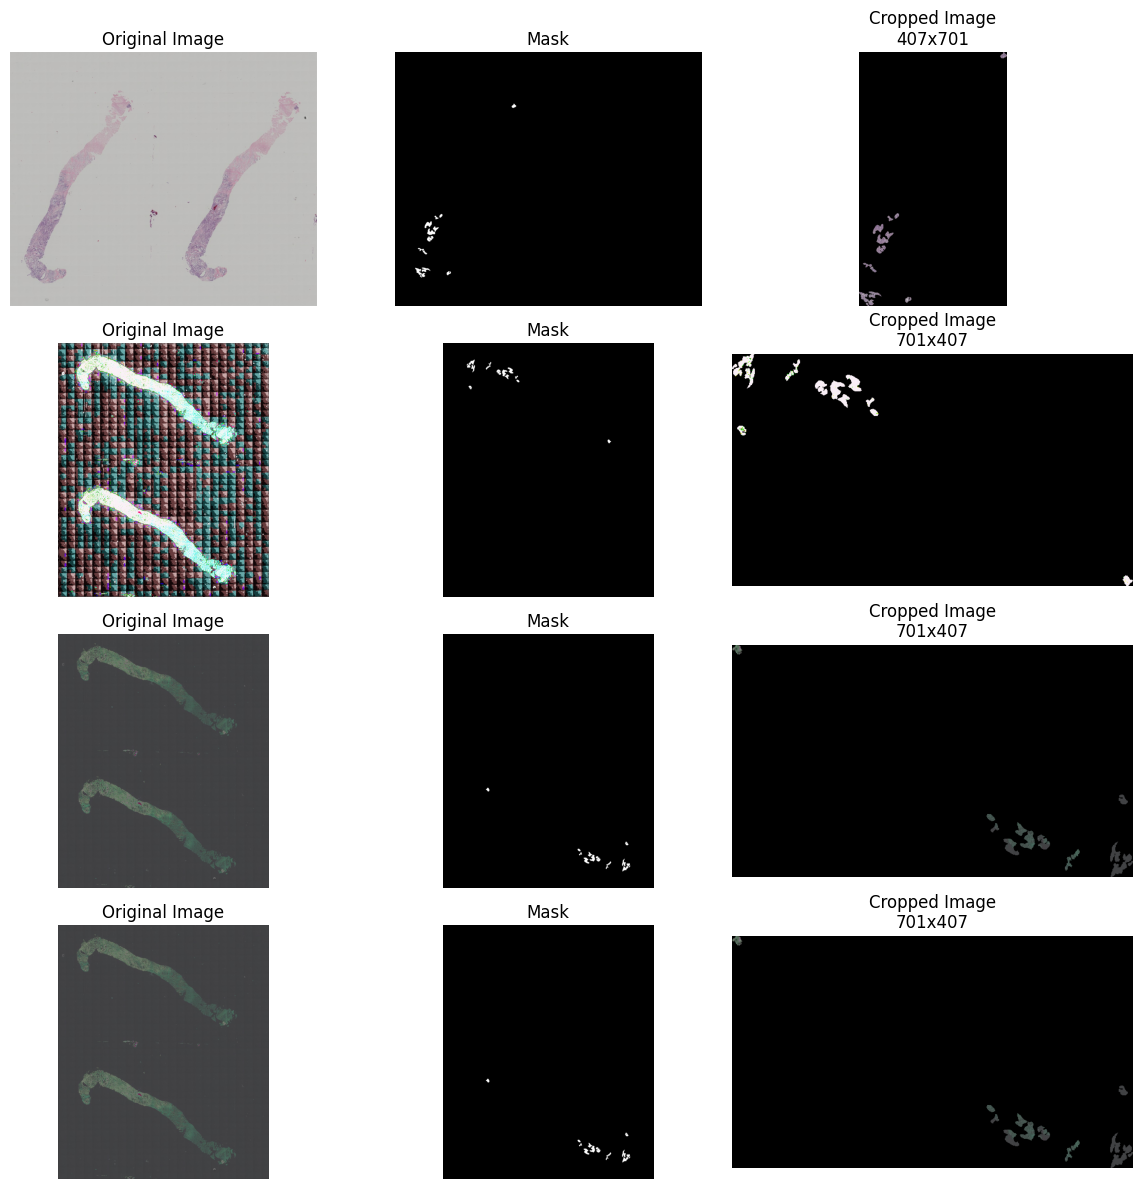

Processing training images: 100%|██████████| 4000/4000 [02:55<00:00, 22.82it/s]



Masked and cropped training images saved.


Processing test images: 100%|██████████| 477/477 [00:57<00:00,  8.30it/s]


Masked and cropped test images saved.


In [8]:
from prep_focusfilter import focus_filter

train_labels = focus_filter(train_img_dir, train_mask_dir, test_img_dir, test_mask_dir, train_labels=train_labels, min_size=(256, 256))

# Dataloaders

In [9]:
from load_patches import load_patches
from load_images import load_images

# ===== PATCH-BASED PROCESSING SETTINGS =====
# Instead of resizing images to 224x224 (which loses detail),
# we extract patches at full resolution and process them separately
PATCH_SIZE = 256  # Size of each patch (256x256)
PATCH_STRIDE = 64
# ==========================================

# For backward compatibility when not using patches
IMG_SIZE = (224, 224) if not PATCH_SIZE and not PATCH_STRIDE else (PATCH_SIZE, PATCH_SIZE)

# Create DataLoaders
# Larger batch size for multi-GPU: DataParallel splits batch across GPUs
# With 2 GPUs: effective batch per GPU = BATCH_SIZE / 2
BATCH_SIZE = 128  # 64 per GPU with DataParallel

## MUTUALLY EXCLUSIVE: Choose either patch-based or full-image loading
# 1) Patch-based loading
# train_loader, val_loader, test_loader, input_shape, num_classes = load_patches(
#     train_img_dir,
#     test_img_dir,
#     train_labels,
#     path_prefix=PATH_PREFIX,
#     patch_size=PATCH_SIZE,
#     patch_stride=PATCH_STRIDE,
#     batch_size=BATCH_SIZE,
#     images_per_batch=50
# )

# # 2) Full-image loading
train_loader, val_loader, test_loader, input_shape, num_classes = load_images(
    train_img_dir,
    test_img_dir,
    train_labels,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


LOADING DATASET
Augmented directory: ./data/train_img/

Distribution in dataset:
label
HER2(+)            1000
Luminal A          1000
Luminal B          1000
Triple negative    1000
Name: count, dtype: int64

Loading images into tensors...
Images tensor shape: torch.Size([4000, 3, 256, 256])
Labels tensor shape: torch.Size([4000])

Train set augmented: 3200 samples
Validation set augmented: 800 samples
Optimization: 4 workers, pin_memory=True, persistent_workers=True

Created DataLoaders:
Val batches: 7
Train batches: 25

Loading test data
Test images shape: torch.Size([477, 3, 256, 256])

DataLoader created:
Test batches: 4
Optimization: 4 workers, pin_memory=True


In [10]:
import torch
# ===== MULTI-GPU SETUP =====
# Check for multiple GPUs and set up DataParallel
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    device = torch.device('cuda:0')
    print(f"Found {num_gpus} GPU(s) available:")
    for i in range(num_gpus):
        print(f" GPU {i}: {torch.cuda.get_device_name(i)}")
    if num_gpus > 1:
        print(f"Multi-GPU training enabled: Will use {num_gpus} GPUs with DataParallel")
    else:
        print(f"Single GPU training")
else:
    device = torch.device('cpu')
    num_gpus = 0
    print("No GPU available, using CPU")
# ===========================

Found 1 GPU(s) available:
 GPU 0: NVIDIA GeForce GTX 1650 with Max-Q Design
Single GPU training


# Parameters

In [11]:
import torch.nn as nn

# Number of training epochs
LEARNING_RATE = 1e-3
EPOCHS = 300
PATIENCE = 50

# Regularisation
DROPOUT_RATE = 0.5       # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0.01         # L2 penalty

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("L1 Penalty:", L1_LAMBDA)
print("L2 Penalty:", L2_LAMBDA)

Epochs: 300
Batch Size: 128
Learning Rate: 0.001
Dropout Rate: 0.5
L1 Penalty: 0
L2 Penalty: 0.01


# Model Builder

In [12]:
# CNN Architecture parameters
# Number of convolutional blocks
NUM_BLOCKS = 1

# Number of conv layers per block
CONVS_PER_BLOCK = 1

# Use strided convolutions instead of pooling
USE_STRIDE = False

# Stride value when USE_STRIDE is True
STRIDE_VALUE = 2

# Padding size
PADDING_SIZE = 1

# Pooling size when USE_STRIDE is False
POOL_SIZE = 2

# Number of channels in first block
INITIAL_CHANNELS = 32

# Channel multiplication factor between blocks
CHANNEL_MULTIPLIER = 2

print("Num Blocks:", NUM_BLOCKS)
print("Convs per Block:", CONVS_PER_BLOCK)
print("Use Stride:", USE_STRIDE)
print("Stride Value:", STRIDE_VALUE)
print("Padding Size:", PADDING_SIZE)
print("Pool Size:", POOL_SIZE)
print("Initial Channels:", INITIAL_CHANNELS)
print("Channel Multiplier:", CHANNEL_MULTIPLIER)

Num Blocks: 1
Convs per Block: 1
Use Stride: False
Stride Value: 2
Padding Size: 1
Pool Size: 2
Initial Channels: 32
Channel Multiplier: 2


In [13]:
# Single convolutional block with multiple conv layers, ReLU and pooling/stride
class VanillaCNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs=1, use_stride=False, stride_value=2, padding_size=1, pool_size=2):
        super().__init__()

        layers = []

        # First convolution: in_channels -> out_channels
        if num_convs == 1:
            # Single conv: apply stride here if use_stride is True
            stride = stride_value if use_stride else 1
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding_size, stride=stride))
        else:
            # Multiple convs: first one always has stride=1
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1))

            # Intermediate convolutions (all with stride=1)
            for i in range(1, num_convs - 1):
                layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1))

            # Last convolution: apply stride here if use_stride is True
            stride = stride_value if use_stride else 1
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding_size, stride=stride))

        # ReLU activation
        layers.append(nn.ReLU())

        # Pooling only if not using stride for spatial reduction
        if not use_stride:
            layers.append(nn.MaxPool2d(kernel_size=pool_size, stride=pool_size))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


# Convolutional Neural Network architecture for CIFAR10 classification
class CNN(nn.Module):
    def __init__(self, input_shape=(3,32,32), num_classes=10, dropout_rate=DROPOUT_RATE,
                 num_blocks=NUM_BLOCKS, convs_per_block=CONVS_PER_BLOCK,
                 use_stride=USE_STRIDE, stride_value=STRIDE_VALUE, padding_size=PADDING_SIZE, pool_size=POOL_SIZE,
                 initial_channels=INITIAL_CHANNELS, channel_multiplier=CHANNEL_MULTIPLIER):
        super().__init__()

        # Build convolutional blocks
        blocks = []
        in_channels = input_shape[0]
        out_channels = initial_channels

        for i in range(num_blocks):
            blocks.append(VanillaCNNBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                num_convs=convs_per_block,
                use_stride=use_stride,
                stride_value=stride_value,
                padding_size=padding_size,
                pool_size=pool_size
            ))

            # Prepare for next block: increase channels
            in_channels = out_channels
            out_channels = out_channels * channel_multiplier

        self.features = nn.Sequential(*blocks)

        # Calculate flattened size after all blocks using a dummy forward pass
        # This approach is robust and works with any configuration of padding, stride, and pooling
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            dummy_output = self.features(dummy_input)
            flattened_size = dummy_output.view(1, -1).shape[1]

        # Classification head: flatten features and apply dropout before final layer
        self.classifier_head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(flattened_size, num_classes)
        )

    # Forward pass through the network
    def forward(self, x):
        x = self.features(x)
        x = self.classifier_head(x)
        return x

In [14]:
from torchsummary import summary

# Instantiate CNN model and move to computing device (CPU/GPU)
cnn_model = CNN(
    input_shape,
    num_classes,
    num_blocks=NUM_BLOCKS,
    convs_per_block=CONVS_PER_BLOCK,
    use_stride=USE_STRIDE,
    stride_value=STRIDE_VALUE,
    padding_size=PADDING_SIZE,
    pool_size=POOL_SIZE,
    initial_channels=INITIAL_CHANNELS,
    channel_multiplier=CHANNEL_MULTIPLIER
    ).to(device)

# Wrap with DataParallel if multiple GPUs are available
if num_gpus > 1:
    cnn_model = nn.DataParallel(cnn_model)
    print(f"✓ Model wrapped with DataParallel for {num_gpus} GPUs")

# Verify model is on GPU
print("\n" + "="*80)
print("MODEL DEVICE VERIFICATION")
print("="*80)
model_device = next(cnn_model.parameters()).device
print(f"Model parameters are on: {model_device}")
if model_device.type == 'cuda':
    print(f"✓ Model successfully loaded on GPU!")
else:
    print(f"✗ WARNING: Model is on CPU, not GPU!")
print("="*80 + "\n")

# Display model architecture summary
# Note: summary() doesn't work well with DataParallel, so we'll use the module
model_for_summary = cnn_model.module if num_gpus > 1 else cnn_model
summary(model_for_summary, input_size=input_shape)


MODEL DEVICE VERIFICATION
Model parameters are on: cuda:0
✓ Model successfully loaded on GPU!

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
         MaxPool2d-3         [-1, 32, 128, 128]               0
   VanillaCNNBlock-4         [-1, 32, 128, 128]               0
           Flatten-5               [-1, 524288]               0
           Dropout-6               [-1, 524288]               0
            Linear-7                    [-1, 4]       2,097,156
Total params: 2,098,052
Trainable params: 2,098,052
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 48.00
Params size (MB): 8.00
Estimated Total Size (MB): 56.75
----------------------------------------------------------------


In [15]:
# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [16]:
# GPU Memory and Utilization Monitoring
if torch.cuda.is_available():
    print("\n" + "="*80)
    print("GPU STATUS BEFORE TRAINING")
    print("="*80)
    for i in range(torch.cuda.device_count()):
        print(f"\nGPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
        print(f"  Memory Reserved: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
        print(f"  Max Memory Allocated: {torch.cuda.max_memory_allocated(i) / 1024**3:.2f} GB")
    print("="*80)


GPU STATUS BEFORE TRAINING

GPU 0: NVIDIA GeForce GTX 1650 with Max-Q Design
  Memory Allocated: 0.02 GB
  Memory Reserved: 0.07 GB
  Max Memory Allocated: 0.05 GB


# Training

In [17]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [18]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [19]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [20]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(),"models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

## Fitting

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set experiment name for this run
EXPERIMENT_NAME = f"test_preproc"

print("="*80)
print(f"TRAINING MODEL")
print("="*80)
print(f"Train loader: {len(train_loader)} batches")
print(f"Val loader: {len(val_loader)} batches")
print("="*80 + "\n")

# Train model and track training history
trained_model, history = fit(
    model=model_for_summary,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    verbose=10,
    experiment_name=EXPERIMENT_NAME,
    patience=PATIENCE
)

# Update best model if current performance is superior
if history['val_f1'][-1] > best_performance:
    best_performance = history['val_f1'][-1]
    best_model = trained_model    
    print(f"\nNew best model saved with F1 Score: {best_performance:.4f}")

TRAINING MODEL
Train loader: 25 batches
Val loader: 7 batches

Training 300 epochs...
Epoch   1/300 | Train: Loss=16.1864, F1 Score=0.2498 | Val: Loss=8.9600, F1 Score=0.1000
Epoch  10/300 | Train: Loss=0.4477, F1 Score=0.9859 | Val: Loss=0.9754, F1 Score=0.7255
Epoch  20/300 | Train: Loss=0.4076, F1 Score=0.9953 | Val: Loss=0.9304, F1 Score=0.7267
Epoch  30/300 | Train: Loss=0.3965, F1 Score=0.9959 | Val: Loss=0.9294, F1 Score=0.7335
Epoch  40/300 | Train: Loss=0.3874, F1 Score=0.9972 | Val: Loss=0.8883, F1 Score=0.7474
Epoch  50/300 | Train: Loss=0.3917, F1 Score=0.9978 | Val: Loss=0.9030, F1 Score=0.7333
Epoch  60/300 | Train: Loss=0.3820, F1 Score=0.9997 | Val: Loss=0.8850, F1 Score=0.7399
Epoch  70/300 | Train: Loss=0.3769, F1 Score=0.9994 | Val: Loss=0.8850, F1 Score=0.7543
Epoch  80/300 | Train: Loss=0.3809, F1 Score=0.9997 | Val: Loss=0.8725, F1 Score=0.7494
Epoch  90/300 | Train: Loss=0.3744, F1 Score=0.9994 | Val: Loss=0.8664, F1 Score=0.7533
Epoch 100/300 | Train: Loss=0.374

C:\Users\frain\AppData\Local\Temp\ipykernel_9472\2800104587.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/"+experiment_name+'

## Plotting

Accuracy over the validation set: 0.7700
Precision over the validation set: 0.7714
Recall over the validation set: 0.7700
F1 score over the validation set: 0.7695


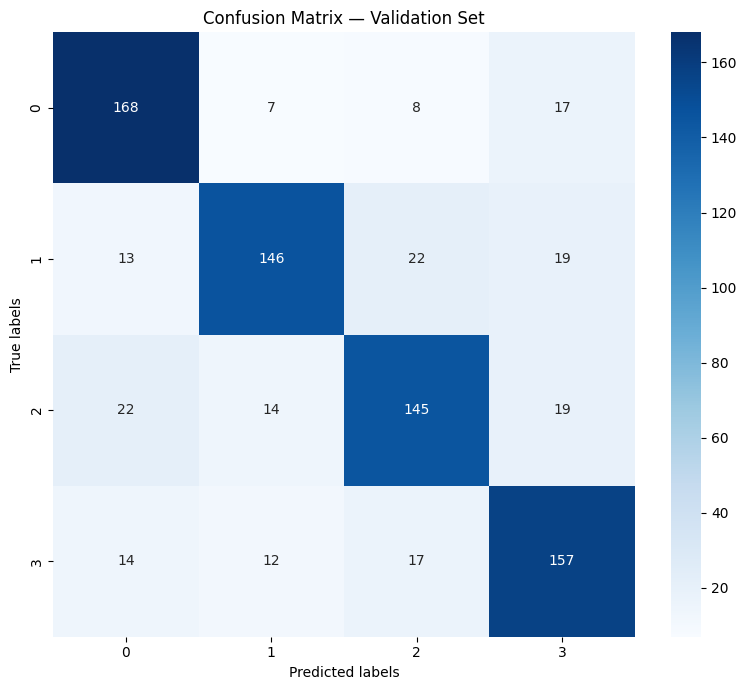

In [22]:
import seaborn as sns

# Get validation predictions
val_preds = []
val_targets = []
best_model.eval()

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        logits = best_model(inputs)
        preds = logits.argmax(dim=1).cpu().numpy()
        
        val_preds.append(preds)
        val_targets.append(targets.numpy())

val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation set metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')

print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix
cm = confusion_matrix(val_targets, val_preds)
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualize confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

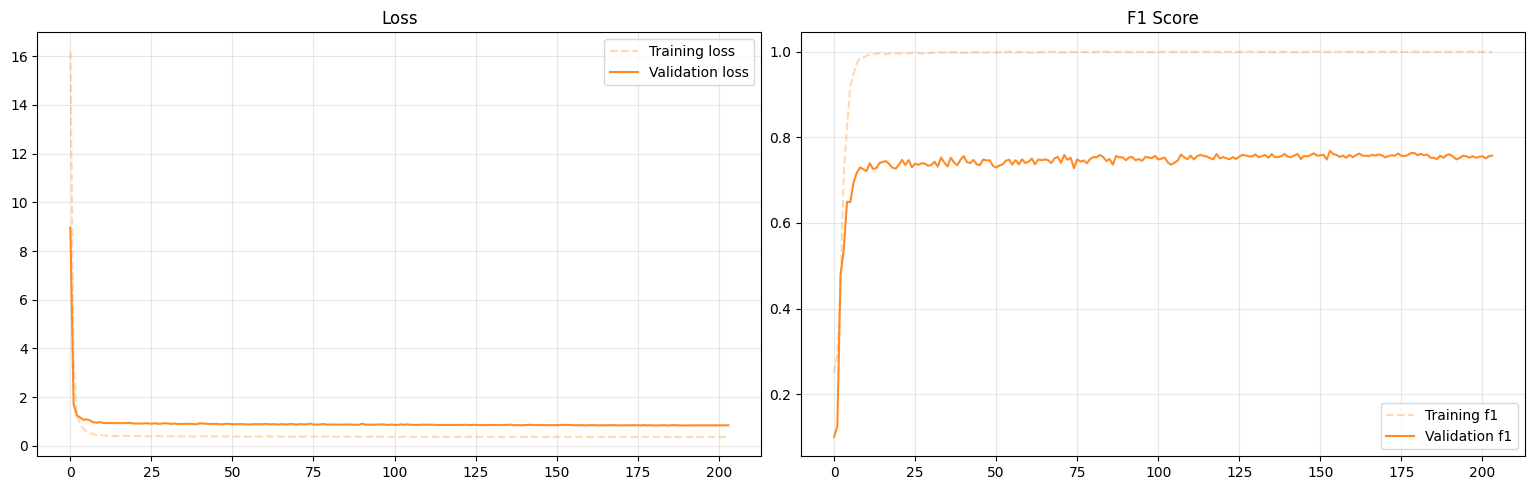

In [23]:
import matplotlib.pyplot as plt

# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

# Inference

In [24]:
# Collect patch predictions and aggregate to image-level predictions
patch_preds = []
patch_probs = []  # Store probabilities for soft voting
best_model.eval()

print(f"Running inference on test set...")


test_filenames = os.listdir(test_img_dir)

with torch.no_grad():
    for batch in test_loader:
        xb = batch[0].to(device)
        
        # Forward pass
        logits = best_model(xb)
        probs = torch.softmax(logits, dim=1).cpu().numpy()  # Get probabilities
        preds = logits.argmax(dim=1).cpu().numpy()  # Get hard predictions
        
        patch_preds.append(preds)
        patch_probs.append(probs)

# Combine all patch predictions
patch_preds = np.concatenate(patch_preds)
patch_probs = np.concatenate(patch_probs)

print(f"✓ Got {len(patch_preds)} patch predictions")

test_preds = np.array(patch_preds)
print(f"✓ Aggregated to {len(test_preds)} image predictions")

Running inference on test set...
✓ Got 477 patch predictions
✓ Aggregated to 477 image predictions


In [25]:
# Create reverse label mapping
reverse_label_map = {v: k for k, v in {'Triple negative': 0, 'Luminal A': 1, 'Luminal B': 2, 'HER2(+)': 3}.items()}


# Create submission dataframe
submission_df = pd.DataFrame({
    'sample_index': test_filenames,
    'label': [reverse_label_map[pred] for pred in test_preds]
})

# Create descriptive filename with all hyperparameters
filename_parts = [
    f"submission_{EXPERIMENT_NAME}",
    f"focus_filter",
    f"blocks_{NUM_BLOCKS}",
    f"convs_{CONVS_PER_BLOCK}",
    f"initchan_{INITIAL_CHANNELS}",
    f"chanmult_{CHANNEL_MULTIPLIER}",
    f"stride_{USE_STRIDE}",
    f"pool_{POOL_SIZE}",
    f"bs_{BATCH_SIZE}",
    f"lr_{LEARNING_RATE}",
    f"drop_{DROPOUT_RATE}",
    f"l1_{L1_LAMBDA}",
    f"l2_{L2_LAMBDA}",
    f"epochs_{EPOCHS}",
    f"patience_{PATIENCE}",
    f"imgsize_{IMG_SIZE[0]}x{IMG_SIZE[1]}",
    f"f1_{val_f1:.4f}"
]
submission_filename = "_".join(filename_parts) + ".csv"

# Save to CSV
submission_df.to_csv(submission_filename, index=False)
print(f"Submission file created: {submission_filename}")
print(f"Total predictions: {len(submission_df)}")
print("\nFirst few predictions:")
print(submission_df.head(10))

Submission file created: submission_test_preproc_focus_filter_blocks_1_convs_1_initchan_32_chanmult_2_stride_False_pool_2_bs_128_lr_0.001_drop_0.5_l1_0_l2_0.01_epochs_300_patience_50_imgsize_256x256_f1_0.7695.csv
Total predictions: 477

First few predictions:
   sample_index            label
0  img_0000.png        Luminal B
1  img_0001.png        Luminal B
2  img_0002.png        Luminal B
3  img_0003.png          HER2(+)
4  img_0004.png          HER2(+)
5  img_0005.png          HER2(+)
6  img_0006.png        Luminal A
7  img_0007.png  Triple negative
8  img_0008.png        Luminal B
9  img_0009.png          HER2(+)
